# Benchmarking
This is a simple benchmarking notebook. It's the python version of the [ImageJ Macro original](https://clij.github.io/clij2-docs/md/benchmarking/)

Note: benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

c:\users\rober\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


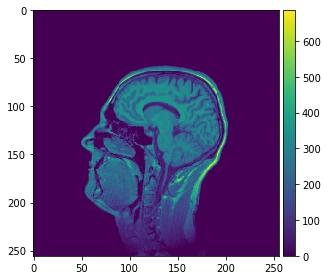

In [1]:
# load example data
from skimage.io import imread, imshow

image = imread('../data/t1-head.tif')

imshow(image[60])

# Mean-3D Filter in scikit-image

CPU mean filter no 0 took 36951.33566856384 ms
CPU mean filter no 1 took 39143.28956604004 ms
CPU mean filter no 2 took 39309.62824821472 ms
CPU mean filter no 3 took 39339.14399147034 ms
CPU mean filter no 4 took 38999.114990234375 ms
CPU mean filter no 5 took 39337.9065990448 ms
CPU mean filter no 6 took 41189.97550010681 ms
CPU mean filter no 7 took 40362.825870513916 ms
CPU mean filter no 8 took 39791.48817062378 ms
CPU mean filter no 9 took 39203.89628410339 ms


c:\users\rober\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


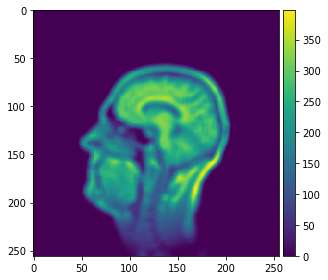

In [2]:
from skimage.morphology import cube
from skimage.filters.rank import mean
import time

structuring_element = cube(7)

output = None
for i in range(0, 10):
    start_time = time.time()
    output = mean(image, structuring_element, out=output)
    print("CPU mean filter no " + str(i) + " took " + str((time.time() - start_time) * 1000) + " ms")

imshow(output[60])

## Mean-3D Filter in py-clEsperanto

In [3]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<GeForce RTX 2070 on Platform: NVIDIA CUDA (1 refs)>

In [4]:
# turn on blocking kernel execution to actually measure processing time. 
# Thanks to Matrin Weigert for that hint! :-)
cle.set_wait_for_kernel_finish(True)

Pushing one image to GPU memory took 49.17573928833008 ms
py-clEsperanto GPU mean filter no 0 took 26.646137237548828 ms
py-clEsperanto GPU mean filter no 1 took 7.186651229858398 ms
py-clEsperanto GPU mean filter no 2 took 7.243871688842773 ms
py-clEsperanto GPU mean filter no 3 took 8.037567138671875 ms
py-clEsperanto GPU mean filter no 4 took 7.213115692138672 ms
py-clEsperanto GPU mean filter no 5 took 6.83140754699707 ms
py-clEsperanto GPU mean filter no 6 took 7.293462753295898 ms
py-clEsperanto GPU mean filter no 7 took 7.478475570678711 ms
py-clEsperanto GPU mean filter no 8 took 7.302761077880859 ms
py-clEsperanto GPU mean filter no 9 took 7.572412490844727 ms
Pulling one image from GPU memory took 28.958797454833984 ms


c:\users\rober\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


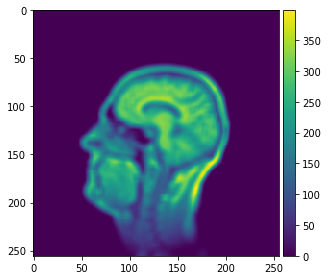

In [5]:
start_time = time.time()
image_gpu = cle.push_zyx(image)
print("Pushing one image to GPU memory took " + str((time.time() - start_time) * 1000) + " ms")

output_gpu = None
for i in range(0, 10):
    start_time = time.time()
    output_gpu = cle.mean_box(image_gpu, output_gpu, 3, 3, 3)
    print("py-clEsperanto GPU mean filter no " + str(i) + " took " + str((time.time() - start_time) * 1000) + " ms")

start_time = time.time()
output = cle.pull_zyx(output_gpu)
print("Pulling one image from GPU memory took " + str((time.time() - start_time) * 1000) + " ms")

imshow(output[60])

## Mean-3D Filter in py-clEsperanto using convolution

Preparing the convolution kernel in GPU memory took 7.099628448486328 ms
py-clEsperanto GPU mean filter using convolution no 0 took 26.929140090942383 ms
py-clEsperanto GPU mean filter using convolution no 1 took 22.93872833251953 ms
py-clEsperanto GPU mean filter using convolution no 2 took 22.94015884399414 ms
py-clEsperanto GPU mean filter using convolution no 3 took 22.937536239624023 ms
py-clEsperanto GPU mean filter using convolution no 4 took 22.93848991394043 ms
py-clEsperanto GPU mean filter using convolution no 5 took 22.939205169677734 ms
py-clEsperanto GPU mean filter using convolution no 6 took 22.938251495361328 ms
py-clEsperanto GPU mean filter using convolution no 7 took 22.94015884399414 ms
py-clEsperanto GPU mean filter using convolution no 8 took 22.937774658203125 ms
py-clEsperanto GPU mean filter using convolution no 9 took 22.937774658203125 ms
Pulling one image from GPU memory took 28.92303466796875 ms


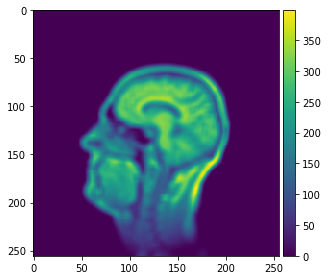

In [6]:
start_time = time.time()
structuring_element = cle.create([7, 7, 7]) # 2 x 3 + 1
cle.set(structuring_element, 1. / 7 / 7 / 7)
print("Preparing the convolution kernel in GPU memory took " + str((time.time() - start_time) * 1000) + " ms")


output_gpu = None
for i in range(0, 10):
    start_time = time.time()
    output_gpu = cle.convolve(image_gpu, structuring_element, output_gpu)
    print("py-clEsperanto GPU mean filter using convolution no " + str(i) + " took " + str((time.time() - start_time) * 1000) + " ms")
    
start_time = time.time()
output = cle.pull_zyx(output_gpu)
print("Pulling one image from GPU memory took " + str((time.time() - start_time) * 1000) + " ms")

imshow(output[60])